## Description

This does a simple 1D case where instead of using a NN, things are done analytically with pdfs or histograms, since the NN output can be predicted from that.

Explores the errors from the bootstrap method.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import time
from stopwatch import Stopwatch, profile

from IPython import display


### Parameters

In [2]:

##--- parameters describing the gen distribution
gen_mu0c = 0.0
gen_sigma0c = 1.0

gen_mu0t = 1.6
gen_sigma0t = 3

#gen_fc = 0.7
gen_fc = 1.0



##--- parameters for the true data, which are different
#nat_mu0c = 0.8
#nat_sigma0c = 0.8

nat_mu0c = 0.2
nat_sigma0c = 0.8

nat_mu0t = 1.5
nat_sigma0t = 3.5

#nat_fc = 0.5
nat_fc = 1.0





##--- parameters for an acceptance turn-on function
acc_t = 3.5
acc_w = 3.0


##--- parameters for an experimental resolution function
#reso_sig = 1.5
#reso_delta = -0.2

reso_sig = 0.5
reso_delta = 0.0



##--- Toy sample parameters
N_toy = 10**6



iterations = 4


dummyval = -30

pdf_points = 40
#x_min = -15
#x_max = 15

x_min = -4
x_max = 4

In [3]:


x = np.linspace(x_min, x_max, pdf_points)

x_binwidth = (x_max-x_min)/(pdf_points-1)
x_bins = np.linspace( x_min-0.5*x_binwidth, x_max+0.5*x_binwidth, pdf_points+1)


##-- mc, gen

pdf_gen0c = (gen_fc)*np.exp(-(x-gen_mu0c)*(x-gen_mu0c)/(2*gen_sigma0c*gen_sigma0c))/gen_sigma0c
pdf_gen0t = (1-gen_fc)*np.exp(-(x-gen_mu0t)*(x-gen_mu0t)/(2*gen_sigma0t*gen_sigma0t))/gen_sigma0t

pdf_gen0 = pdf_gen0c + pdf_gen0t



##-- nature, gen  (this is data with perfect resolution, which may be different from gen above)
pdf_nat0c = (nat_fc)*np.exp(-(x-nat_mu0c)*(x-nat_mu0c)/(2*nat_sigma0c*nat_sigma0c))/nat_sigma0c
pdf_nat0t = (1-nat_fc)*np.exp(-(x-nat_mu0t)*(x-nat_mu0t)/(2*nat_sigma0t*nat_sigma0t))/nat_sigma0t

pdf_nat0 = pdf_nat0c + pdf_nat0t






##-- an acceptance function
func_acc = 1./(1+np.exp(acc_w*(x-acc_t)))



##-- a resolution function
pdf_reso = np.exp(-(x-reso_delta)*(x-reso_delta)/(2*reso_sig*reso_sig))
pdf_reso = pdf_reso / np.sum(pdf_reso)



##-- mc with resolution
pdf_sim = np.convolve(pdf_gen0, pdf_reso,'same')

##-- nature with resolution (this is the real data)
pdf_nat = np.convolve( pdf_nat0, pdf_reso, 'same')


##-- mc with resolution and acceptance
pdf_sim_acc = pdf_sim * func_acc

##-- data with resolution and acceptance
pdf_nat_acc = pdf_nat * func_acc


### Gen pdf from the sum of two components

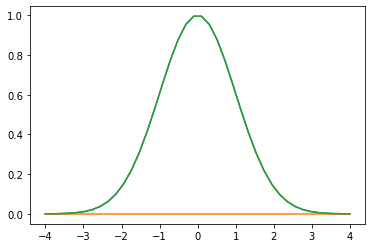

In [4]:
plt.plot(x,pdf_gen0c)
plt.plot(x,pdf_gen0t)
plt.plot(x,pdf_gen0)
plt.show()

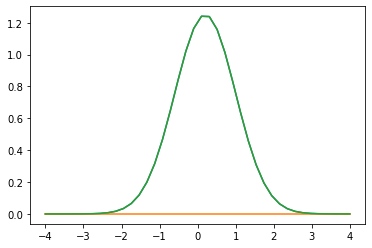

In [5]:
plt.plot(x,pdf_nat0c)
plt.plot(x,pdf_nat0t)
plt.plot(x,pdf_nat0)
plt.show()

### An acceptance function

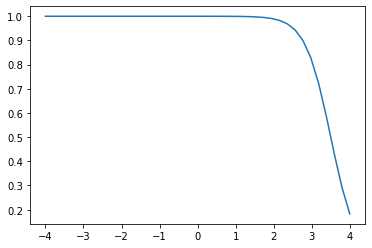

In [6]:
plt.plot(x,func_acc)
plt.show()

### A resolution function

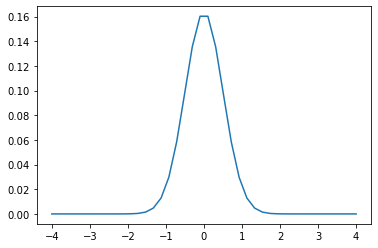

In [7]:
plt.plot(x,pdf_reso)
plt.show()

### A comparison of gen and sim, before acceptance

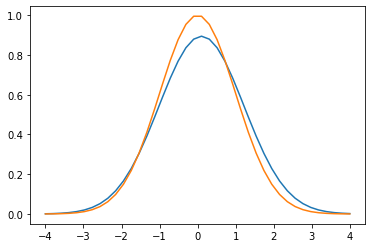

In [8]:
plt.plot(x,pdf_sim)
plt.plot(x,pdf_gen0)
plt.show()

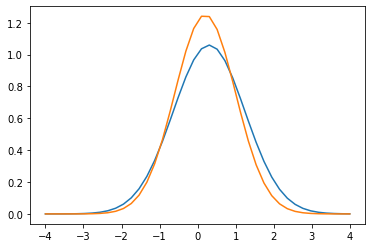

In [9]:
plt.plot(x,pdf_nat)
plt.plot(x,pdf_nat0)
plt.show()

### compare gen with nature (perfect resolution)

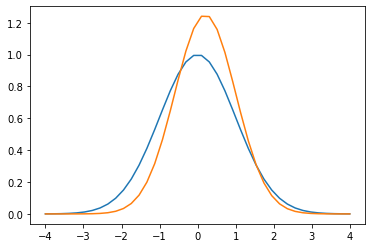

In [10]:
plt.plot(x,pdf_gen0)
plt.plot(x,pdf_nat0*(np.sum(pdf_gen0)/np.sum(pdf_nat0)))
plt.show()

### Compare sim with nature (including resolution)

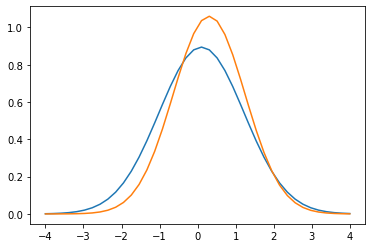

In [11]:
plt.plot(x,pdf_sim)
plt.plot(x,pdf_nat*(np.sum(pdf_sim)/np.sum(pdf_nat)))
plt.show()

### Adding sim with acceptance to the comparison

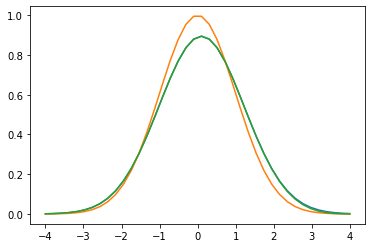

In [12]:
plt.plot(x,pdf_sim)
plt.plot(x,pdf_gen0)
plt.plot(x,pdf_sim_acc)
plt.show()

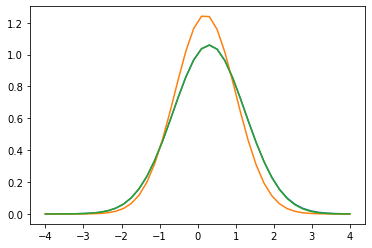

In [13]:
plt.plot(x,pdf_nat)
plt.plot(x,pdf_nat0)
plt.plot(x,pdf_nat_acc)
plt.show()

### Compare sim with nature including acceptance

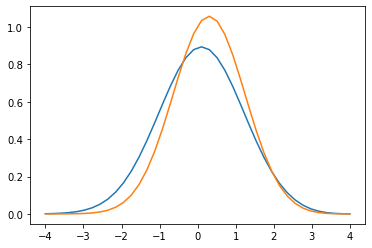

In [14]:
plt.plot(x,pdf_sim_acc)
plt.plot(x,pdf_nat_acc*(np.sum(pdf_sim_acc)/np.sum(pdf_nat_acc)))
plt.show()

### Generate the toy MC

In [15]:
toy_gen0 = np.concatenate( [
    np.random.normal( gen_mu0c, gen_sigma0c, np.int32(np.rint(N_toy*gen_fc)) ),
    np.random.normal( gen_mu0t, gen_sigma0t, np.int32(np.rint(N_toy*(1.-gen_fc))) ) ]
)

toy_sim = np.array( toy_gen0 + np.random.normal( reso_delta, reso_sig, N_toy) )

toy_acc_val_sim = 1./(1+np.exp(acc_w*(toy_sim-acc_t)))
toy_acc_sim_rndm = np.random.uniform(0,1,N_toy)

toy_sim_acc = np.array(toy_sim)
toy_sim_acc[toy_acc_sim_rndm>toy_acc_val_sim] = dummyval




toy_nat0 = np.concatenate( [
    np.random.normal( nat_mu0c, nat_sigma0c, np.int32(np.rint(N_toy*nat_fc)) ),
    np.random.normal( nat_mu0t, nat_sigma0t, np.int32(np.rint(N_toy*(1.-nat_fc))) ) ]
)

toy_nat = np.array( toy_nat0 + np.random.normal( reso_delta, reso_sig, N_toy) )

toy_acc_val_nat = 1./(1+np.exp(acc_w*(toy_nat-acc_t)))
toy_acc_nat_rndm = np.random.uniform(0,1,N_toy)

toy_nat_acc = np.array(toy_nat)
toy_nat_acc[toy_acc_nat_rndm>toy_acc_val_nat] = dummyval



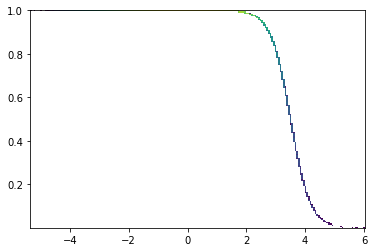

In [16]:
plt.hist2d( toy_sim, toy_acc_val_sim, bins=200, norm=mpl.colors.LogNorm())
plt.show()

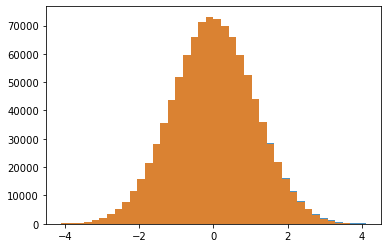

In [17]:
plt.hist(toy_sim, bins=x_bins, alpha=0.8)
plt.hist(toy_sim_acc, bins=x_bins, alpha=0.8)
plt.show()

## Validation of gen and sim
Histograms should agree exactly with the pdf curves

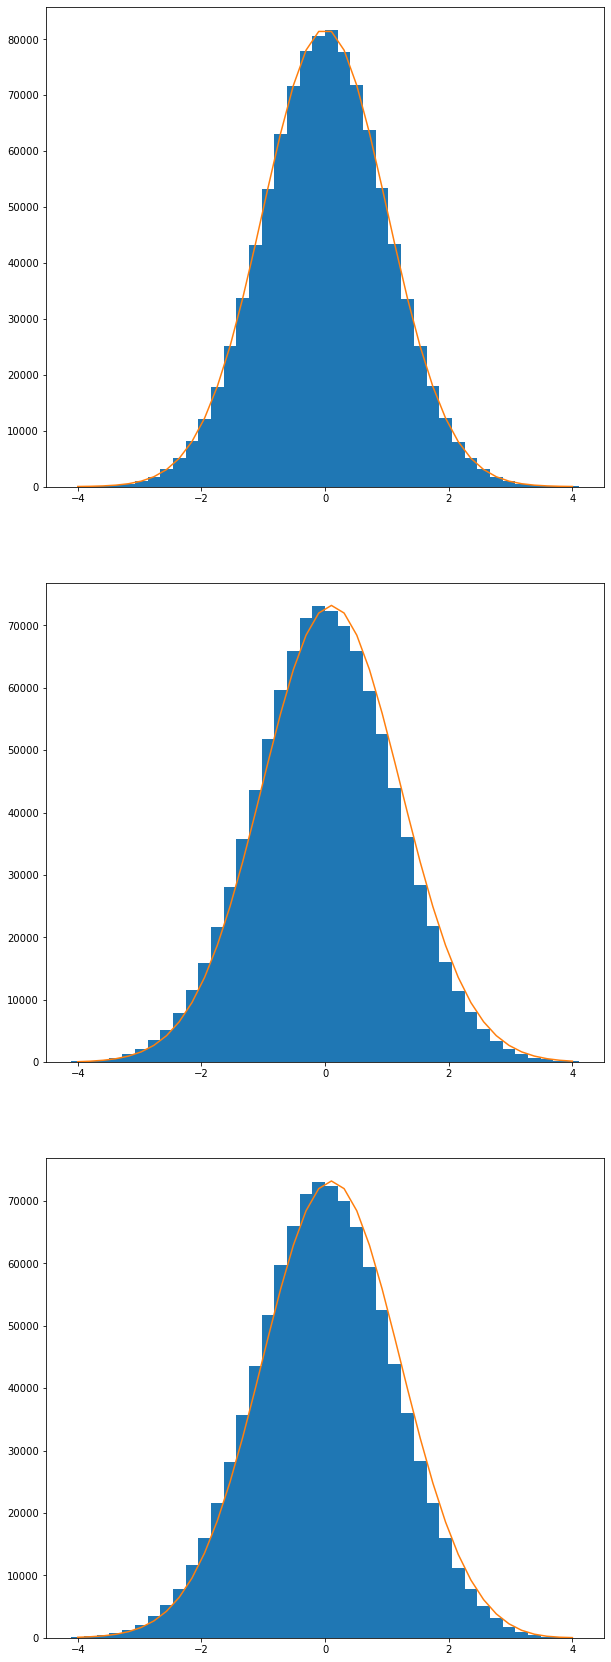

In [18]:
fig,ax = plt.subplots(3,1,figsize=(10,30))

ax[0].hist( toy_gen0, bins=x_bins)
ax[0].plot( x, pdf_gen0*(N_toy/np.sum(pdf_gen0)) )

ax[1].hist( toy_sim, bins=x_bins)
ax[1].plot( x, pdf_sim*(N_toy/np.sum(pdf_sim)) )

ax[2].hist( toy_sim_acc, bins=x_bins)
ax[2].plot( x, pdf_sim_acc*(N_toy/np.sum(pdf_sim)) )

plt.show()

## Validation of the "data" or nature samples
Histograms should agree exactly with the pdf curves

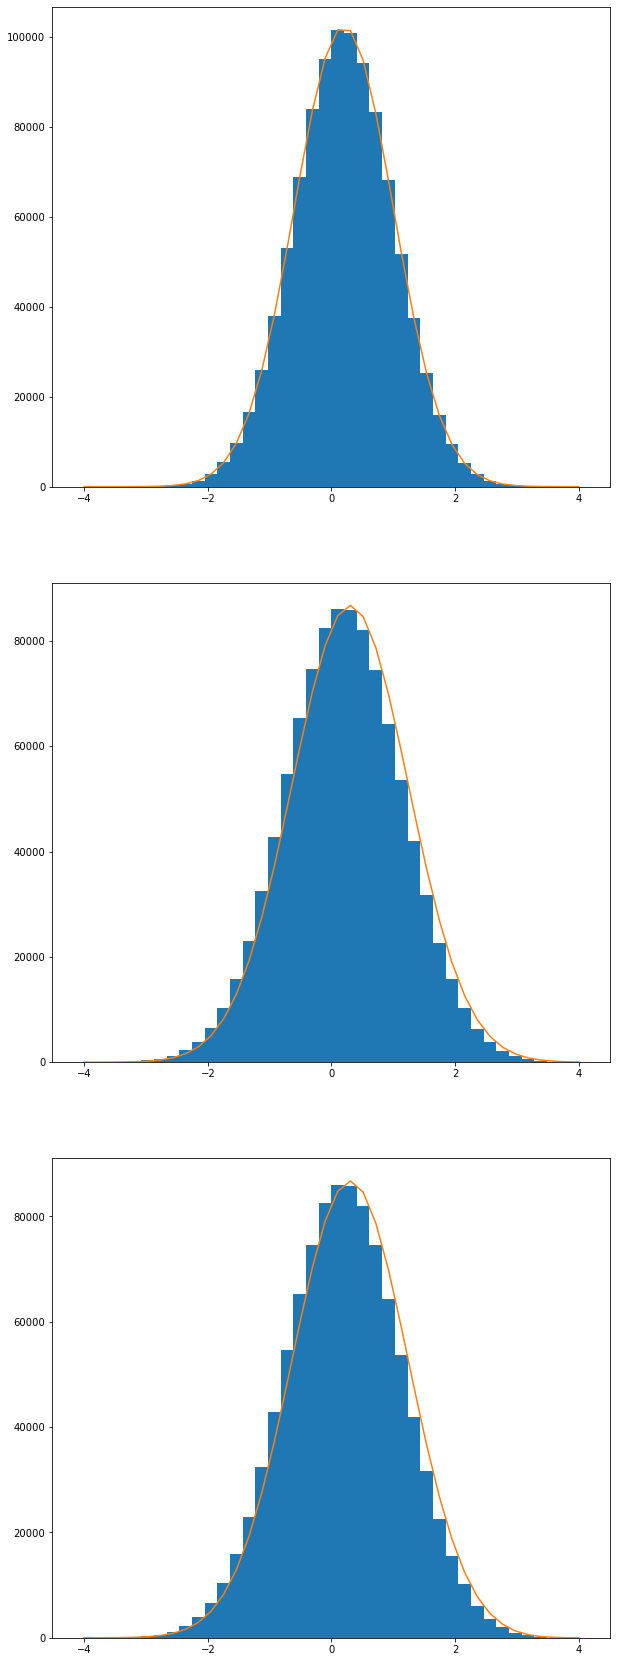

In [19]:
fig,ax = plt.subplots(3,1,figsize=(10,30))

ax[0].hist( toy_nat0, bins=x_bins)
ax[0].plot( x, pdf_nat0*(N_toy/np.sum(pdf_nat0)) )

ax[1].hist( toy_nat, bins=x_bins)
ax[1].plot( x, pdf_nat*(N_toy/np.sum(pdf_nat)) )

ax[2].hist( toy_nat_acc, bins=x_bins)
ax[2].plot( x, pdf_nat_acc*(N_toy/np.sum(pdf_nat)) )

plt.show()

## Inspect the simulation and nature toy datasets in 2D (sim vs gen)

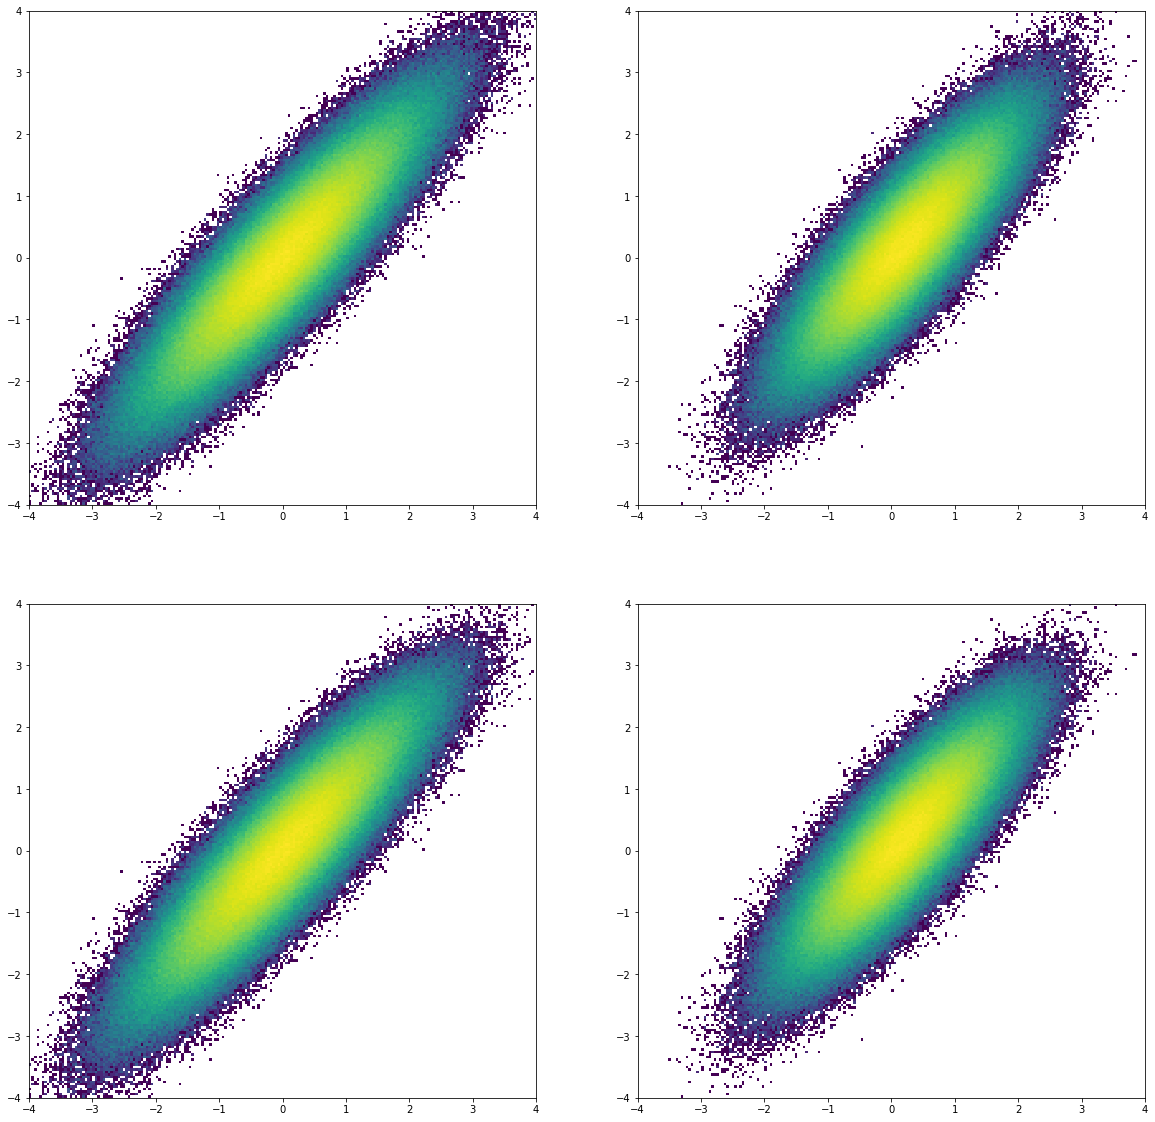

In [20]:
fig,ax = plt.subplots(2,2,figsize=(20,20))

ax[0][0].hist2d( toy_gen0, toy_sim, bins=200, norm=mpl.colors.LogNorm(), range=([x_min,x_max],[x_min,x_max]) )
ax[0][1].hist2d( toy_nat0, toy_nat, bins=200, norm=mpl.colors.LogNorm(), range=([x_min,x_max],[x_min,x_max]) )

ax[1][0].hist2d( toy_gen0, toy_sim_acc, bins=200, norm=mpl.colors.LogNorm(), range=([x_min,x_max],[x_min,x_max]) )
ax[1][1].hist2d( toy_nat0, toy_nat_acc, bins=200, norm=mpl.colors.LogNorm(), range=([x_min,x_max],[x_min,x_max]) )

plt.show()

## Each event has a sim bin index and a gen0 bin index

The **step 1** weight is a function of the sim value, so we need the sim histogram bin index for that.

The **step 2** weight is a function of the gen0 value, so we need the gen0 histogram bin index for that.



**Watch out!**  Digitize returns 0 for values below bins and len(x_bins)+1 for values above bins, so it returns 1 for values in the first bin.  If want to use this as an array index, need to shift by one!  

In [21]:
toy_sim_bin_indices = np.digitize( toy_sim, x_bins)

In [22]:
toy_sim_bin_indices = toy_sim_bin_indices - 1

In [23]:
toy_sim_bin_indices_safe = np.clip( toy_sim_bin_indices, 0, pdf_points-1 )

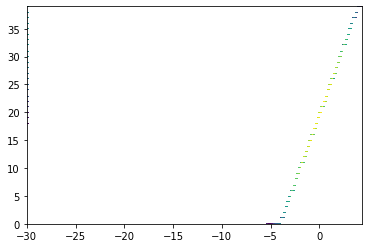

In [24]:
plt.hist2d( toy_sim_acc, toy_sim_bin_indices_safe, bins=200, norm=mpl.colors.LogNorm() )
plt.show()

In [25]:
toy_gen0_bin_indices = np.digitize( toy_gen0, x_bins)

In [26]:
toy_gen0_bin_indices = toy_gen0_bin_indices - 1

In [27]:
toy_gen0_bin_indices_safe = np.clip(toy_gen0_bin_indices, 0, pdf_points-1 )

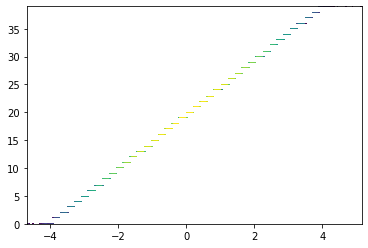

In [28]:
plt.hist2d( toy_gen0, toy_gen0_bin_indices_safe, bins=200, norm=mpl.colors.LogNorm() )
plt.show()

## Analytic version of the unfolding

### Iteration 1, step 1 (weight sim to nature)

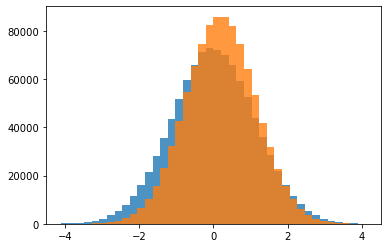

In [29]:
hist_sim = plt.hist( toy_sim, bins=x_bins, alpha=0.8 )
hist_nat = plt.hist( toy_nat, bins=x_bins, alpha=0.8 )


#hist_sim = plt.hist( toy_sim_acc, bins=x_bins, alpha=0.8 )
#hist_nat = plt.hist( toy_nat_acc, bins=x_bins, alpha=0.8 )

Set bins with zeros to really small numbers to avoid NaNs in division.

In [30]:
hist_sim_safe = np.clip(hist_sim[0],1e-9,1e25)
hist_nat_safe = np.clip(hist_nat[0],1e-9,1e25)

In [31]:
weight_step1 = hist_nat_safe / hist_sim_safe

In [32]:
weight_step1_clipped = np.clip(weight_step1, -10, 10)

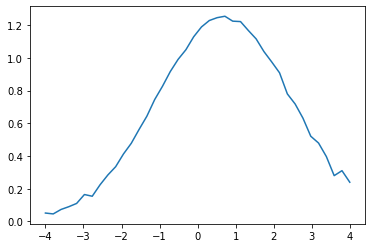

In [33]:
plt.plot( x, weight_step1_clipped)

### Iteration 1, step 2 (weight gen to gen with pull weights)

In [34]:
pull_weights = weight_step1_clipped[ toy_sim_bin_indices_safe ]


In [35]:
pull_weights

array([1.04915614, 0.99025226, 1.25378934, ..., 1.2449962 , 0.74462088,
       1.1885817 ])

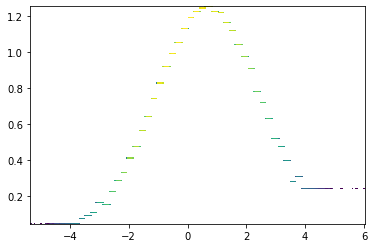

In [36]:
plt.hist2d( toy_sim, pull_weights, bins=200, norm=mpl.colors.LogNorm() )
plt.show()

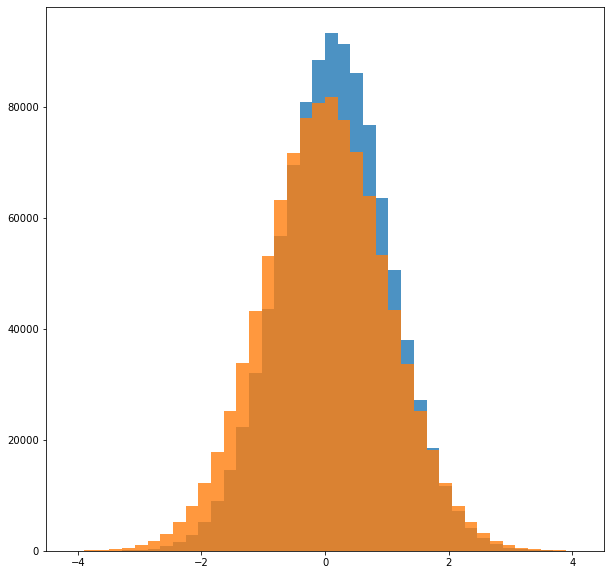

In [37]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
hist_genw = plt.hist( toy_gen0[pull_weights!=10], weights=pull_weights[pull_weights!=10], bins=x_bins, alpha=0.8)
hist_gen0 = plt.hist( toy_gen0[pull_weights!=10], bins=x_bins, alpha=0.8)
plt.show()

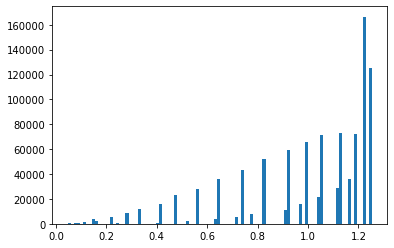

In [38]:
plt.hist( pull_weights, bins=100)
plt.show()

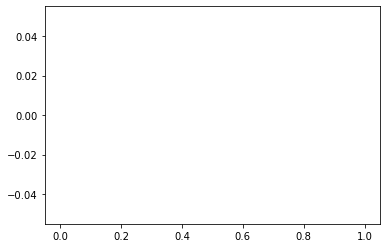

In [39]:
plt.hist(toy_sim[pull_weights==10], bins=100)
plt.show()

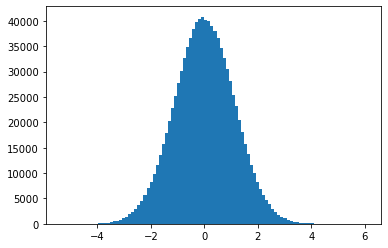

In [40]:
plt.hist(toy_sim[pull_weights!=10], bins=100)
plt.show()

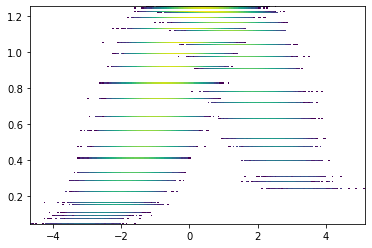

In [41]:
plt.hist2d( toy_gen0, pull_weights, bins=200, norm=mpl.colors.LogNorm() )
plt.show()

In [42]:
hist_genw_safe = np.clip(hist_genw[0],1e-9,1e25)
hist_gen0_safe = np.clip(hist_gen0[0],1e-9,1e25)

In [43]:
weight_step2 = hist_genw_safe / hist_gen0_safe

In [44]:
weight_step2_clipped = np.clip(weight_step2, -10, 10)

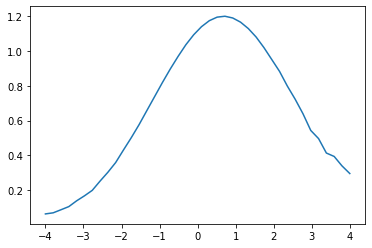

In [45]:
plt.plot(x, weight_step2_clipped)

In [46]:
push_weights = weight_step2_clipped[ toy_gen0_bin_indices_safe ]

In [47]:
push_weights

array([0.81994373, 0.96989966, 1.19626354, ..., 1.19626354, 0.89744564,
       1.19626354])

In [48]:
len(push_weights)

1000000

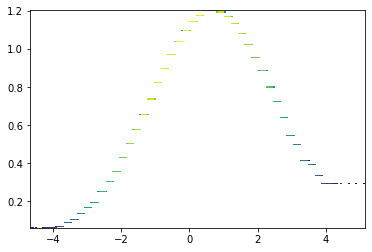

In [49]:
plt.hist2d( toy_gen0, push_weights, bins=200, norm=mpl.colors.LogNorm() )
plt.show()

## Iteration 2, step 1

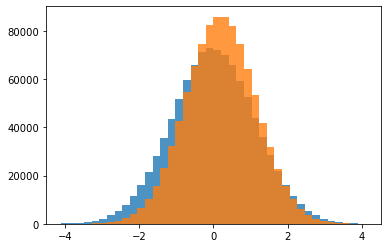

In [50]:

hist_sim = plt.hist( toy_sim, bins=x_bins, alpha=0.8 )
hist_nat = plt.hist( toy_nat, bins=x_bins, alpha=0.8 )

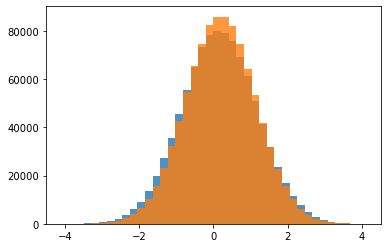

In [51]:
hist_sim = plt.hist( toy_sim, bins=x_bins, weights=push_weights, alpha=0.8 )
hist_nat = plt.hist( toy_nat, bins=x_bins, alpha=0.8 )

In [52]:
hist_sim_safe = np.clip(hist_sim[0],1e-9,1e25)
hist_nat_safe = np.clip(hist_nat[0],1e-9,1e25)

In [53]:
weight_step1 = hist_nat_safe / hist_sim_safe

In [54]:
weight_step1_clipped = np.clip(weight_step1, -10, 10)

## Iteration 2, step 2

In [55]:
#pull_weights = weight_step1_clipped[ toy_sim_bin_indices_safe ]
pull_weights = push_weights * weight_step1_clipped[ toy_sim_bin_indices_safe ]

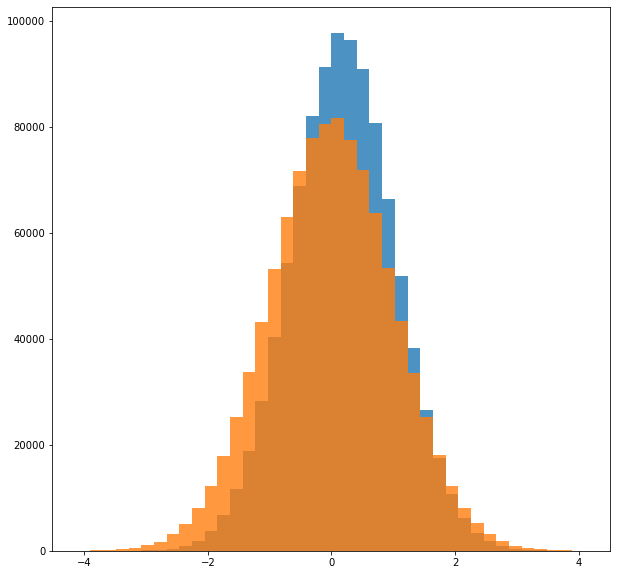

In [56]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
hist_genw = plt.hist( toy_gen0[pull_weights!=10], weights=pull_weights[pull_weights!=10], bins=x_bins, alpha=0.8)
hist_gen0 = plt.hist( toy_gen0[pull_weights!=10], bins=x_bins, alpha=0.8)
plt.show()

In [57]:
hist_genw_safe = np.clip(hist_genw[0],1e-9,1e25)
hist_gen0_safe = np.clip(hist_gen0[0],1e-9,1e25)

In [58]:
weight_step2 = hist_genw_safe / hist_gen0_safe

In [59]:
weight_step2_clipped = np.clip(weight_step2, -10, 10)

In [60]:
push_weights = weight_step2_clipped[ toy_gen0_bin_indices_safe ]

## Iteration 3, step 1

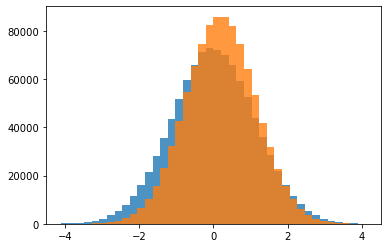

In [61]:

hist_sim = plt.hist( toy_sim, bins=x_bins, alpha=0.8 )
hist_nat = plt.hist( toy_nat, bins=x_bins, alpha=0.8 )

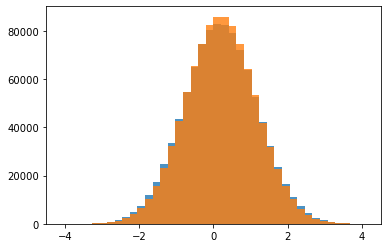

In [62]:
hist_sim = plt.hist( toy_sim, bins=x_bins, weights=push_weights, alpha=0.8 )
hist_nat = plt.hist( toy_nat, bins=x_bins, alpha=0.8 )

In [63]:
hist_sim_safe = np.clip(hist_sim[0],1e-9,1e25)
hist_nat_safe = np.clip(hist_nat[0],1e-9,1e25)

In [64]:
weight_step1 = hist_nat_safe / hist_sim_safe

In [65]:
weight_step1_clipped = np.clip(weight_step1, -10, 10)

## Iteration 3, step 2

In [66]:
pull_weights = push_weights * weight_step1_clipped[ toy_sim_bin_indices_safe ]

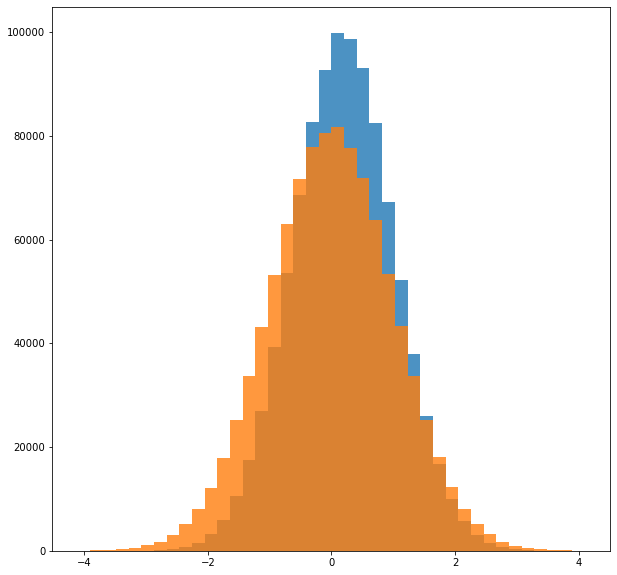

In [67]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
hist_genw = plt.hist( toy_gen0[pull_weights!=10], weights=pull_weights[pull_weights!=10], bins=x_bins, alpha=0.8)
hist_gen0 = plt.hist( toy_gen0[pull_weights!=10], bins=x_bins, alpha=0.8)
plt.show()

In [68]:
hist_genw_safe = np.clip(hist_genw[0],1e-9,1e25)
hist_gen0_safe = np.clip(hist_gen0[0],1e-9,1e25)

In [69]:
weight_step2 = hist_genw_safe / hist_gen0_safe

In [70]:
weight_step2_clipped = np.clip(weight_step2, -10, 10)

In [71]:
push_weights = weight_step2_clipped[ toy_gen0_bin_indices_safe ]

## Iteration 4, step 1

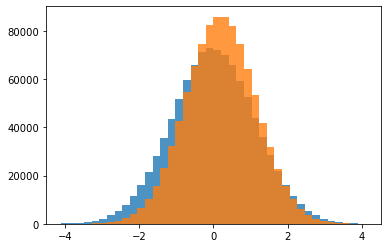

In [72]:
hist_sim = plt.hist( toy_sim, bins=x_bins, alpha=0.8 )
hist_nat = plt.hist( toy_nat, bins=x_bins, alpha=0.8 )

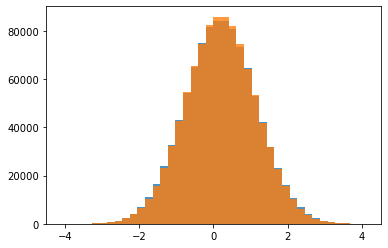

In [73]:
hist_sim = plt.hist( toy_sim, bins=x_bins, weights=push_weights, alpha=0.8 )
hist_nat = plt.hist( toy_nat, bins=x_bins, alpha=0.8 )

In [74]:
hist_sim_safe = np.clip(hist_sim[0],1e-9,1e25)
hist_nat_safe = np.clip(hist_nat[0],1e-9,1e25)

In [75]:
weight_step1 = hist_nat_safe / hist_sim_safe

In [76]:
weight_step1_clipped = np.clip(weight_step1, -10, 10)

## Iteration 4, step 2

In [77]:
pull_weights = push_weights * weight_step1_clipped[ toy_sim_bin_indices_safe ]

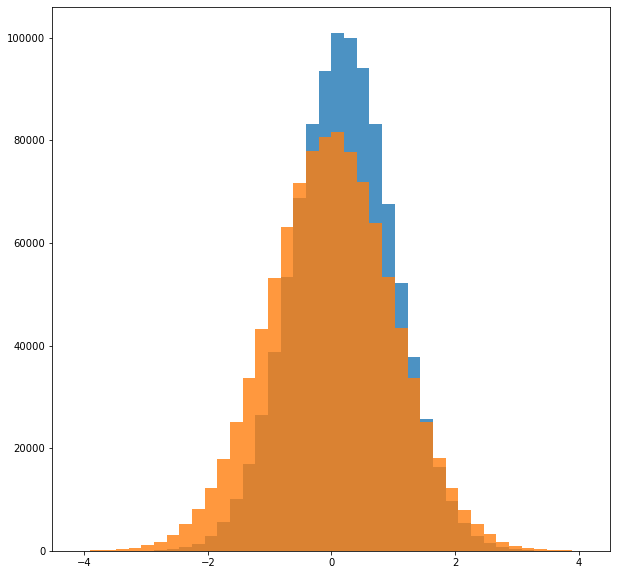

In [78]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
hist_genw = plt.hist( toy_gen0[pull_weights!=10], weights=pull_weights[pull_weights!=10], bins=x_bins, alpha=0.8)
hist_gen0 = plt.hist( toy_gen0[pull_weights!=10], bins=x_bins, alpha=0.8)
plt.show()

In [79]:
hist_genw_safe = np.clip(hist_genw[0],1e-9,1e25)
hist_gen0_safe = np.clip(hist_gen0[0],1e-9,1e25)

In [80]:
weight_step2 = hist_genw_safe / hist_gen0_safe

In [81]:
weight_step2_clipped = np.clip(weight_step2, -10, 10)

In [82]:
push_weights = weight_step2_clipped[ toy_gen0_bin_indices_safe ]

## Iteration 5, step 1

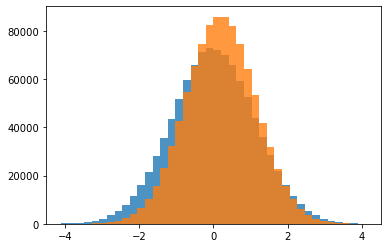

In [83]:
hist_sim = plt.hist( toy_sim, bins=x_bins, alpha=0.8 )
hist_nat = plt.hist( toy_nat, bins=x_bins, alpha=0.8 )

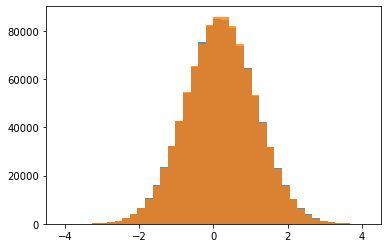

In [84]:
hist_sim = plt.hist( toy_sim, bins=x_bins, weights=push_weights, alpha=0.8 )
hist_nat = plt.hist( toy_nat, bins=x_bins, alpha=0.8 )

## Do the OmniFold iterations in a loop

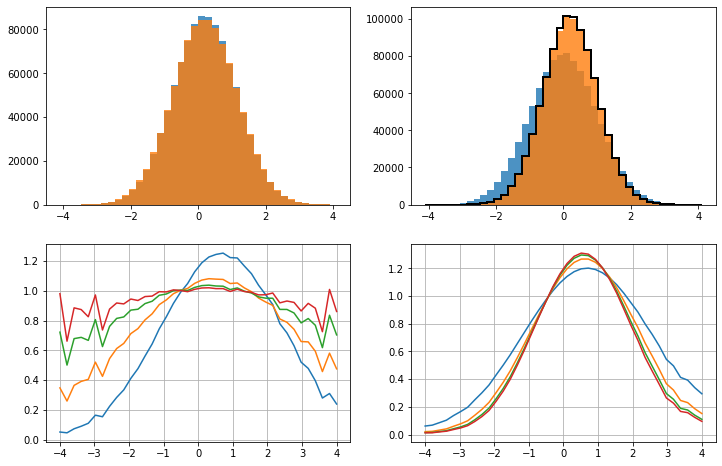




 All Done





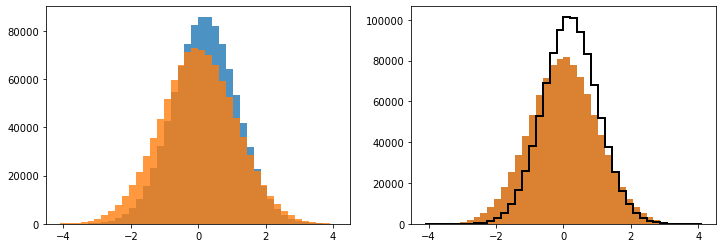

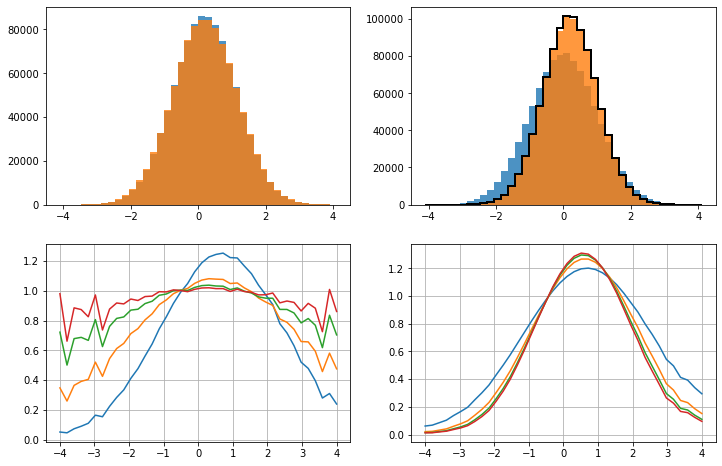

In [85]:

pull_weights = np.ones( len(toy_sim) )
push_weights = np.ones( len(toy_gen0) )


fig,ax = plt.subplots(1,2,figsize=(12,4))



ax[0].cla()
hist_nat = ax[0].hist( toy_nat, bins=x_bins, alpha=0.8 )
hist_sim = ax[0].hist( toy_sim, bins=x_bins, alpha=0.8 )


ax[1].cla()
hist_genw = ax[1].hist( toy_gen0[pull_weights!=10], bins=x_bins, alpha=0.8)
hist_gen0 = ax[1].hist( toy_gen0[pull_weights!=10], bins=x_bins, alpha=0.8)
ax[1].hist( toy_nat0, bins=x_bins, linewidth=2, density=False, color='black', histtype = 'step')

display.display(plt.gcf())

print("\n\n Initialization.")




fig,ax = plt.subplots(2,2,figsize=(12,8))

for i in range(0,iterations) :
    
    print("\n\n ======== Iteration %d" % i )
    
    display.clear_output(wait =True)

    #-- step 1
    
    ax[0][0].cla()
    hist_nat = ax[0][0].hist( toy_nat, bins=x_bins, alpha=0.8 )
    hist_sim = ax[0][0].hist( toy_sim, bins=x_bins, weights=push_weights, alpha=0.8 )
    
    hist_sim_safe = np.clip(hist_sim[0],1e-9,1e25)
    hist_nat_safe = np.clip(hist_nat[0],1e-9,1e25)
    
    weight_step1 = hist_nat_safe / hist_sim_safe
    
    weight_step1_clipped = np.clip(weight_step1, -10, 10)
    
    ax[1][0].plot(x, weight_step1_clipped)
    ax[1][0].grid(True)
    
    
    pull_weights = push_weights * weight_step1_clipped[ toy_sim_bin_indices_safe ]
    
    
    
    #-- step 2

    ax[0][1].cla()
    hist_gen0 = ax[0][1].hist( toy_gen0[pull_weights!=10], bins=x_bins, alpha=0.8)
    hist_genw = ax[0][1].hist( toy_gen0[pull_weights!=10], weights=pull_weights[pull_weights!=10], bins=x_bins, alpha=0.8)

    ax[0][1].hist( toy_nat0, bins=x_bins, linewidth=2, density=False, color='black', histtype = 'step')
    

    
    hist_genw_safe = np.clip(hist_genw[0],1e-9,1e25)
    hist_gen0_safe = np.clip(hist_gen0[0],1e-9,1e25)
    
    weight_step2 = hist_genw_safe / hist_gen0_safe
    
    weight_step2_clipped = np.clip(weight_step2, -10, 10)
    
    ax[1][1].plot(x, weight_step2_clipped)
    ax[1][1].grid(True)
    
    push_weights = weight_step2_clipped[ toy_gen0_bin_indices_safe ]

    
    
    display.display(plt.gcf())
    

    
print("\n\n\n All Done\n\n\n")    